We shall start by importing the essential libraries.

In [1]:
### IMPORTING LIBRARIES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix, classification_report, accuracy_score, recall_score, roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter

Next, we clean the data and bring it to a form which will make the model building process easy. This phase is done exactly the same way as in 00 - Stroke EDA.

In [2]:
### DATA PREPARATION
stroke = pd.read_csv('healthcare-dataset-stroke-data.csv', na_values = [np.NaN, ' '])

df = pd.DataFrame(stroke)
df = df.drop(['id'], axis = 1)

num_vars = df.select_dtypes(include = ['int64', 'float64'])
cat_vars = df.select_dtypes(include = 'object')
feature_names = collections.defaultdict(str)
for name in num_vars.columns:
    feature_names[name]
for name in cat_vars.columns:
    feature_names[name]

mean_imputer = SimpleImputer(strategy = 'mean')
imputed_vars = mean_imputer.fit_transform(num_vars)
df_imputed = pd.DataFrame(np.hstack([imputed_vars, cat_vars]), columns = feature_names)

df_imputed['age'] = df_imputed['age'].astype('float64')
df_imputed['hypertension'] = df_imputed['hypertension'].astype('int64')
df_imputed['heart_disease'] = df_imputed['heart_disease'].astype('int64')
df_imputed['avg_glucose_level'] = df_imputed['avg_glucose_level'].astype('float64')
df_imputed['bmi'] = df_imputed['bmi'].astype('float64')
df_imputed['stroke'] = df_imputed['stroke'].astype('int64')

capping = num_vars.select_dtypes(include = 'float64')
for col in df_imputed.columns:
    if col in capping.columns:
        percentile = df_imputed[col].quantile([0.05, 0.95]).values
        df_imputed[col] = df_imputed[col].clip(lower = percentile[0], upper = percentile[1])
        
df_final = pd.get_dummies(df_imputed, columns = ['gender', 'ever_married', 'work_type', 'Residence_type',
                                              'smoking_status'], drop_first = True)

Now we separate the independent and dependent features; we label them X and y respectively. Then, we separate data for training and testing sets in the ratio of 8:2, making sure that the imbalance in the levels of the target variable, y, is maintained in both the sets. In other words, both the training and testing sets have the same proportion of people who did not suffer from stroke and those who did.

In [3]:
### SEPARATING TRAIN AND TEST SETS
X = df_final.drop(['stroke'], axis = 1)
y = df_final['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 99)

Before we build our K-Nearest Neighbours model, remember that the data was highly unbalanced in that the number of people who did not suffer from stroke was far more than those who did. To overcome this problem, we shall perform oversampling using SMOTE technique which will produce new samples with their outcome as having stroke in order to make both the levels of y equal. SMOTE stands for Synthetic Minority Oversampling Technique and it uses the nearest neighbors of the minority class(having a stroke) to produce new and synthetic data points.

In [4]:
### OVERSAMPLING USING SMOTE
X_train_res, y_train_res = SMOTE(random_state = 99).fit_resample(X_train, y_train)
print(sorted(Counter(y_train_res).items()))

[(0, 3889), (1, 3889)]


Since KNN makes use of distances, it would be wise to scale the continuous variables. Doing so would eliminate the risk of variables with large values having a larger say in the model.

In [5]:
### SCALING CONTINUOUS VARIABLES
scaler = StandardScaler().fit(X_train_res)
X_train_scaled = scaler.transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

We now go on to make a simple KNN model, which will serve as our baseline. Since it is our first model, we shall only consider two nearest points as neighbours for each case. We fit the training data and plot the confusion matrix.

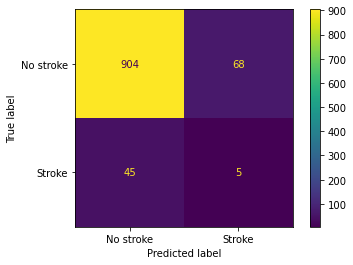

In [6]:
### CREATING A BASELINE MODEL
clf_knn = KNeighborsClassifier(n_neighbors = 2, n_jobs = -1)
clf_knn.fit(X_train_scaled, y_train_res)
plot_confusion_matrix(clf_knn, X_test_scaled, y_test, display_labels = ['No stroke', 'Stroke'])

Before we proceed, let's take a look at the distribution of the levels of y in our dataset.

In [7]:
df['stroke'].value_counts(normalize = True)

0    0.951272
1    0.048728
Name: stroke, dtype: float64

Here, we see that around 95% of the people in our dataset have not suffered from stroke as opposed to just about 5% who actually have. This means that even if our model predicts every person as not having a stroke, the model will still be 95% accurate at the very least. So, in this case, accuracy is a deceptive metric. 


What we should rather be concerned with is the number of people who actually had stroke but were not identified by the model as having stroke i.e. the False Negatives. Lower the FN value, lower is the risk of overlooking a possible case of stroke and thus better is the model because the main objective of the model here should be to possibly save lives by correctly identifying a stroke case as early as possible. To reduce the FN value, we need to ensure that the recall of stroke cases is high since recall and FN are inversely proportional.


So, we shall calculate the accuracy and recall values for the predictions made by the model.

In [8]:
### CALCULATING ESSENTIAL METRICS 
y_pred_knn = clf_knn.predict(X_test_scaled)
print(classification_report(y_test, y_pred_knn, target_names = ['No stroke', 'Stroke']))
print('Accuracy: %f' % accuracy_score(y_test, y_pred_knn))
print('Recall score: %f' % recall_score(y_test, y_pred_knn))

              precision    recall  f1-score   support

   No stroke       0.95      0.93      0.94       972
      Stroke       0.07      0.10      0.08        50

    accuracy                           0.89      1022
   macro avg       0.51      0.52      0.51      1022
weighted avg       0.91      0.89      0.90      1022

Accuracy: 0.889432
Recall score: 0.100000


If we look at the confusion matrix, we see that out of the 50 cases that had actually suffered from stroke, only 5 were correctly predicted as having a stroke by our model while 45 were overlooked. This gives us a recall score of 10% while the accuracy is about 89%. Right away, we can say that this model does a poor job.

Next, we plot the ROC curve and calculate the AUC score.

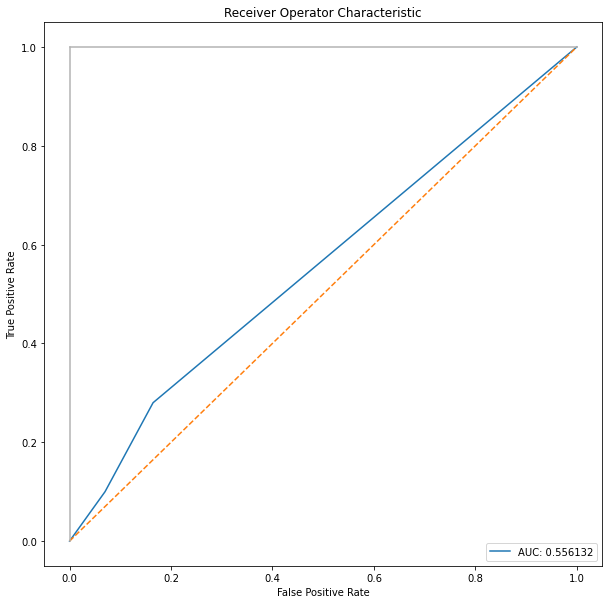

In [9]:
### PLOTTING ROC CURVE WITH AUC VALUE
y_prob_knn = clf_knn.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, threshold = roc_curve(y_test, y_prob_knn)
roc_auc = roc_auc_score(y_test, y_prob_knn)
plt.figure(figsize = (10, 10))
plt.title('Receiver Operator Characteristic')
plt.plot(fpr, tpr, label = 'AUC: %f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], ls = '--')
plt.plot([0, 0], [1, 0], c = '0.7')
plt.plot([1, 1], c = '0.7')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

We get an AUC score of about 0.5561, further proving that model is a poor one.


Now that we have our baseline model, let us try to improve it by finding the most appropriate number of neighbors i.e. the best
k value. We can take a range of possible k values and use them to create numerous models with which we can calculate the recall score for both the training and testing sets. We can plot these recall scores on a graph against the k values.

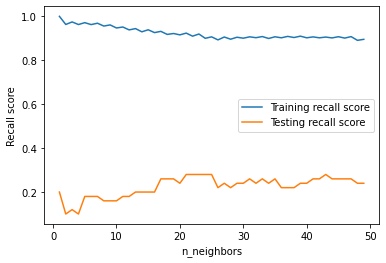

In [10]:
### PLOTTING RECALL SCORES FOR TRAINING AND TESTING AGAINST K VALUES
training_recall = []
testing_recall = []
n_values = range(1, 50)
for n_neighbors in n_values:
    clf = KNeighborsClassifier(n_neighbors = n_neighbors, n_jobs = -1)
    clf.fit(X_train_scaled, y_train_res)
    y_train_pred = clf.predict(X_train_scaled)
    y_test_pred = clf.predict(X_test_scaled)
    training_recall.append(recall_score(y_train_res, y_train_pred))
    testing_recall.append(recall_score(y_test, y_test_pred))
plt.plot(n_values, training_recall, label = 'Training recall score')
plt.plot(n_values, testing_recall, label = 'Testing recall score')
plt.xlabel('n_neighbors')
plt.ylabel('Recall score')
plt.legend()
plt.show()

Here, we see that as the k value increases, the recall for testing set also tends to increase while the recall for the training set gradually decreases. When 20 < k < 25, the recall for testing set reaches around 30% but we should be careful with such high values for k since large k values tend to overfit the model to the current testing data and perform poorly with new data.


Now, we will try to improve the baseline model by tuning it's parameters. For this, we shall use a grid search across possible values for the parameters n_neighbors and metric. We create a pipeline which first separates and scales some portion of the training data, then uses it to create a model which will test on the remaining data; we will do this 5 times over via 5 fold cross-validation. As we are trying to decrease the FN value, we will use roc_auc as our scoring parameter.


The parameter metric defines the type of distance calculation which is used to find the nearest neighbours. We take the following distance types as candidates:
1. euclidean: uses the L2 norm to calculate the distance, i.e. the square root of the sum of the squared differences between two points
2. manhattan: uses the L1 norm to calculate the distance, i.e. the sum of the absolute differences between two points
3. chebyshev: uses the L-infinity norm to calculate the distance, i.e. the maximum of the absolute differences between two points
4. minkowski: uses the L-p norm to calculate the distance, i.e. the general form of euclidean, manhattan and chebyshev.

In [11]:
### TUNING PARAMETER VALUES USING GRID SEARCH
knn = KNeighborsClassifier()
scaler = StandardScaler()
pipe = Pipeline([('scaler', scaler), ('classifier', knn)])
search_space = [{'classifier__n_neighbors': range(1, 50),
                'classifier__metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']}]
grid_fit = GridSearchCV(pipe, 
                       search_space,
                       scoring = 'roc_auc',
                       verbose = 2,
                       cv = 5,
                       n_jobs = -1)
grid_fit.fit(X_train_res, y_train_res)
print('Best n_neighbors value: %f' % grid_fit.best_estimator_.get_params()['classifier__n_neighbors'])
print('Best metric: %s' % grid_fit.best_estimator_.get_params()['classifier__metric'])

Fitting 5 folds for each of 196 candidates, totalling 980 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 980 out of 980 | elapsed:  3.9min finished


Best n_neighbors value: 5.000000
Best metric: manhattan


Now, with these tuned parameter values, we shall create our final K-Nearest Neighbors model.

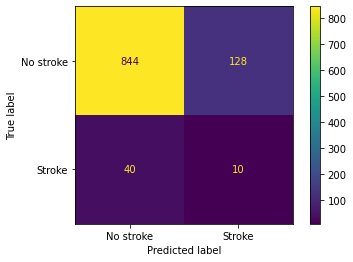

In [12]:
### CREATING THE FINAL MODEL
clf_knn = KNeighborsClassifier(n_neighbors = 5, metric = 'manhattan', n_jobs = -1)
clf_knn.fit(X_train_scaled, y_train_res)
plot_confusion_matrix(clf_knn, X_test_scaled, y_test, display_labels = ['No stroke', 'Stroke'])

Of the 50 stroke cases, the final model predicts only 10 correctly while it fails to do the same for the remaining 40. This means that the model is still a poor one. 

In [13]:
### CALCULATING ESSENTIAL METRICS
y_pred_knn = clf_knn.predict(X_test_scaled)
print(classification_report(y_test, y_pred_knn, target_names = ['No stroke', 'Stroke']))
print('Accuracy: %f' % accuracy_score(y_test, y_pred_knn))
print('Recall score: %f' % recall_score(y_test, y_pred_knn))

              precision    recall  f1-score   support

   No stroke       0.95      0.87      0.91       972
      Stroke       0.07      0.20      0.11        50

    accuracy                           0.84      1022
   macro avg       0.51      0.53      0.51      1022
weighted avg       0.91      0.84      0.87      1022

Accuracy: 0.835616
Recall score: 0.200000


The recall score has gone up to 20% which makes this model better than the baseline. Also, keep in mind that the accuracy has gone down to about 84%, pointing to the already established fact that accuracy is a deceptive metric in this case.

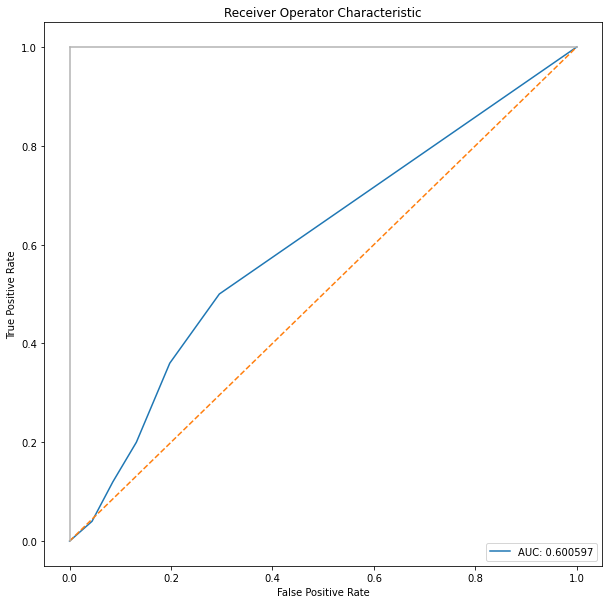

In [14]:
### PLOTTING ROC CURVE WITH AUC VALUE
y_prob_knn = clf_knn.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, threshold = roc_curve(y_test, y_prob_knn)
roc_auc = roc_auc_score(y_test, y_prob_knn)
plt.figure(figsize = (10, 10))
plt.title('Receiver Operator Characteristic')
plt.plot(fpr, tpr, label = 'AUC: %f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], ls = '--')
plt.plot([0, 0], [1, 0], c = '0.7')
plt.plot([1, 1], c = '0.7')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

Finally, the AUC score for this model is 0.6006, which is more than it's predecessor. This further proves that, despite having just 20% recall score and being a poor model in general, the final model is the still better than the baseline.